In [1]:
import torch
import matplotlib.pyplot as plt

from diffusers.models import AutoencoderKL

import sys
sys.path.append('../src')
from models import *
import utils as utils
from torchvision.utils import make_grid

utils.seed_everything(0, cudnn_deterministic=False)

autoenc = AutoencoderKL(
    down_block_types=['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
    up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
    block_out_channels=[128, 256, 512, 512],
    layers_per_block=2,
    sample_size=256
)
autoenc.load_state_dict(torch.load('../src/sd_image_var_autoenc.pth'))
autoenc.requires_grad_(False)
autoenc.eval()
pass

/admin/home-atom_101/python_envs/fmri/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: not using cudnn.deterministic


In [2]:
voxel2sd = Voxel2StableDiffusionModel()
state_dict = torch.load('../train_logs/models/autoencoder/test/ckpt-epoch099.pth', map_location='cpu')["model_state_dict"]
for key in list(state_dict.keys()):
    if 'module.' in key:
        state_dict[key.replace('module.', '')] = state_dict[key]
        del state_dict[key]
voxel2sd.load_state_dict(state_dict)
voxel2sd.eval()
pass

In [3]:
data_commit = '9947586218b6b7c8cab804009ddca5045249a38d'
train_url = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/{data_commit}/datasets_pscotti_naturalscenesdataset_resolve_{data_commit}_webdataset_train/train_subj01_{{0..49}}.tar"
val_url = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/{data_commit}/datasets_pscotti_naturalscenesdataset_resolve_{data_commit}_webdataset_val/val_subj01_0.tar"
cache_dir = 'cache'
n_cache_recs = 0

train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
    4, 
    'images',
    num_devices=1,
    num_workers=1,
    train_url=train_url,
    val_url=val_url,
    cache_dir=cache_dir,
    n_cache_recs=n_cache_recs,
    voxels_key="nsdgeneral.npy",
)

Getting dataloaders...
train_url /fsx/proj-medarc/fmri/natural-scenes-dataset/9947586218b6b7c8cab804009ddca5045249a38d/datasets_pscotti_naturalscenesdataset_resolve_9947586218b6b7c8cab804009ddca5045249a38d_webdataset_train/train_subj01_{0..49}.tar
val_url /fsx/proj-medarc/fmri/natural-scenes-dataset/9947586218b6b7c8cab804009ddca5045249a38d/datasets_pscotti_naturalscenesdataset_resolve_9947586218b6b7c8cab804009ddca5045249a38d_webdataset_val/val_subj01_0.tar
num_devices 1
num_workers 1
batch_size 4
global_batch_size 4
num_worker_batches 6245
num_train 24983
num_val 492
cache_dir None
validation: num_worker_batches 123


In [4]:
voxels, images, _ = next(iter(val_dl))

In [5]:
with torch.no_grad():
    preds = voxel2sd(voxels.float())
    reconst = autoenc.decode(preds/0.18215).sample

pred_grid = make_grid(((reconst/2 + 0.5)*255).byte(), nrow=2)
orig_grid = make_grid((images*255).byte(), nrow=2)

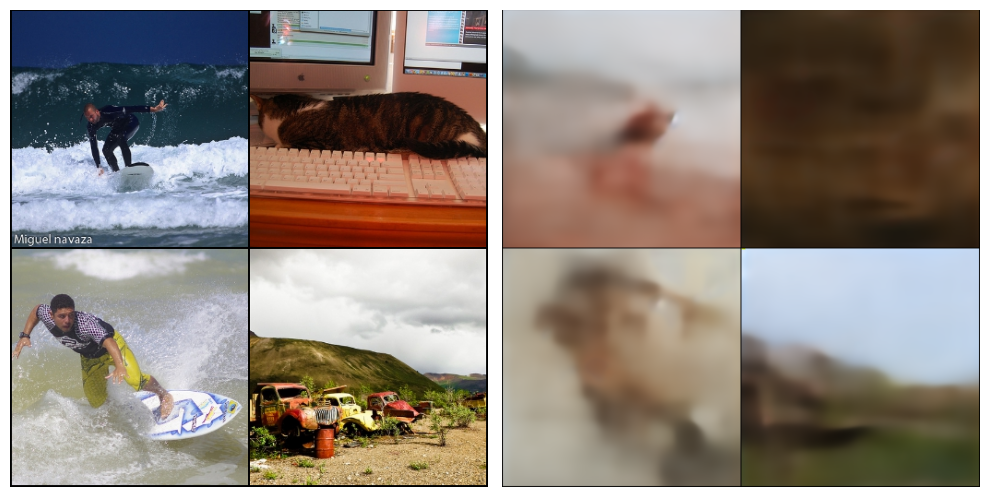

In [6]:
fig,ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(orig_grid.permute(1,2,0))
ax[0].axis('off')
ax[1].imshow(pred_grid.permute(1,2,0))
ax[1].axis('off')
fig.tight_layout()

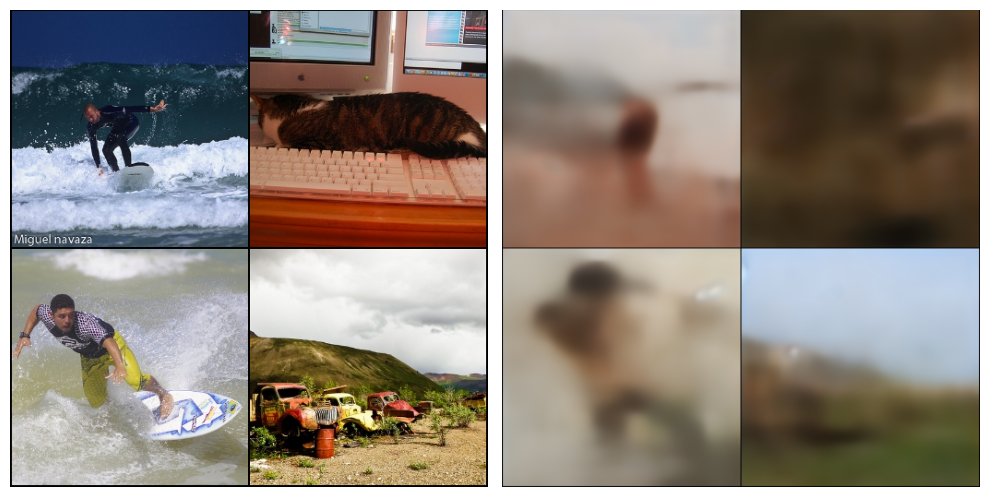

In [6]:
fig,ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(orig_grid.permute(1,2,0))
ax[0].axis('off')
ax[1].imshow(pred_grid.permute(1,2,0))
ax[1].axis('off')
fig.tight_layout()

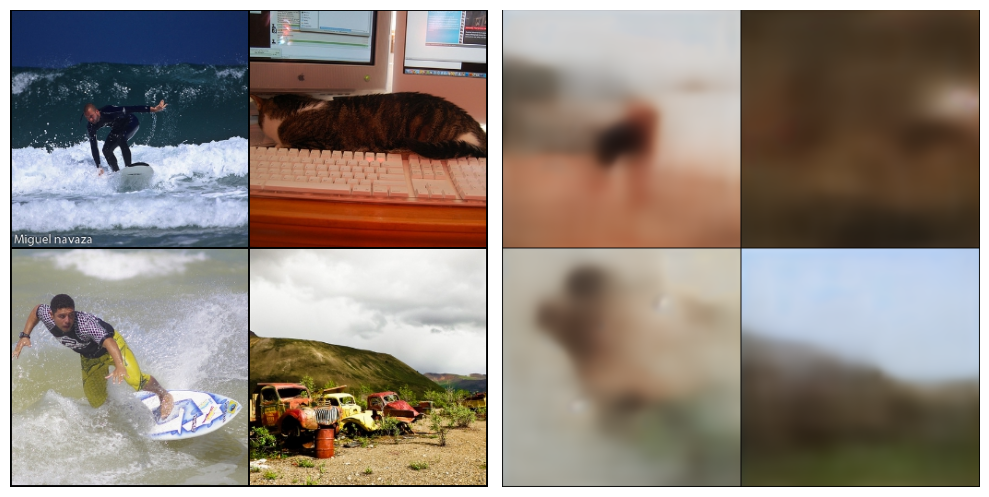

In [6]:
fig,ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(orig_grid.permute(1,2,0))
ax[0].axis('off')
ax[1].imshow(pred_grid.permute(1,2,0))
ax[1].axis('off')
fig.tight_layout()

In [10]:
images.shape

torch.Size([4, 3, 256, 256])